# Import Required Libraries
Import necessary libraries such as TensorFlow, NumPy, and Matplotlib.

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Load Models
Load the quantized models 'bestmodel_quantized.tflite' and 'my_model_quantized.tflite' and the unquantized models 'my_model.keras' and 'bestmodel.keras'.

In [5]:
# Load the unquantized models
my_model = tf.keras.models.load_model('./kaggle/working/my_model.keras')
bestmodel = tf.keras.models.load_model('./kaggle/working/bestmodel.keras')

# Load the quantized models
interpreter_my_model_quantized = tf.lite.Interpreter(model_path='./kaggle/working/my_model_quantized.tflite')
interpreter_bestmodel_quantized = tf.lite.Interpreter(model_path='./kaggle/working/bestmodel_quantized.tflite')

# Allocate tensors for the quantized models
interpreter_my_model_quantized.allocate_tensors()
interpreter_bestmodel_quantized.allocate_tensors()

# Get input and output details for the quantized models
input_details_my_model_quantized = interpreter_my_model_quantized.get_input_details()
output_details_my_model_quantized = interpreter_my_model_quantized.get_output_details()

input_details_bestmodel_quantized = interpreter_bestmodel_quantized.get_input_details()
output_details_bestmodel_quantized = interpreter_bestmodel_quantized.get_output_details()

# Evaluate Unquantized Models
Evaluate the performance of the unquantized models on the test dataset and calculate metrics such as accuracy, precision, recall, and AUC.

In [11]:
img_width_bestmodel = 256
img_height_bestmodel = 256
img_width_my_model = 224
img_height_my_model = 224

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir_bestmodel = "./kaggle/input/skin-diseases/kaggle/train"
test_dir_bestmodel =  "./kaggle/input/skin-diseases/kaggle/test"
val_dir_bestmodel = "./kaggle/input/skin-diseases/kaggle/val"

train_data_bestmodel = image_dataset_from_directory(train_dir,label_mode = "categorical", image_size = (img_height, img_width), batch_size = 16, shuffle = True, seed = 42)
test_data_bestmodel = image_dataset_from_directory(test_dir,label_mode = "categorical", image_size = (img_height, img_width), batch_size = 16, shuffle = True, seed = 42)
val_data_bestmodel = image_dataset_from_directory(val_dir,label_mode = "categorical", image_size = (img_height, img_width), batch_size = 16, shuffle = True, seed = 42)

Found 30909 files belonging to 6 classes.
Found 3928 files belonging to 6 classes.
Found 3923 files belonging to 6 classes.


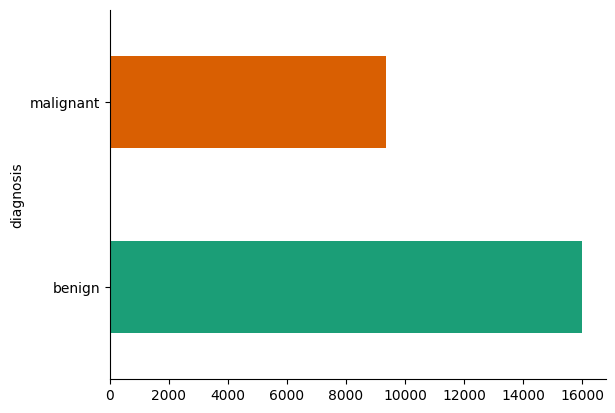

In [20]:
# Load Dataset
BASE_PATH = "./kaggle"
metadata = pd.read_csv(f'{BASE_PATH}/ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv(f'{BASE_PATH}/ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
merge_df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
merge_df['target'] = merge_df[['MEL', 'BCC', 'AK', 'SCC']].sum(axis=1) # 1 for Malignant
diagnosis_map = {0: 'benign', 1: 'malignant'}
merge_df['diagnosis'] = merge_df['target'].map(diagnosis_map)
df = merge_df.loc[:, ['image', 'target', 'diagnosis']]
df['images'] = f'{BASE_PATH}/input/ISIC-2019/' + df['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
df.head()
# @title diagnosis

import seaborn as sns
df.groupby('diagnosis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
# Split the dataset into features and target
X = df[["images"]]
y = df["target"]

# Convert target values to float32
y = y.astype('float32')

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X, y = X_test, y_test
X_validation, X_test, y_validation, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Create a TensorFlow dataset from the preprocessed data
def load_and_preprocess_image(image_path):
    # Read and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # adjust size as needed
    return image

def create_tf_dataset(X, y, batch_size=32, shuffle=True,repeat =True):
    image_paths = X['images'].tolist()
    X.drop('images',axis=1,inplace=True)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))

    # Read and preprocess images, include them in the batch
    def load_image(image_path, label):
        image = load_and_preprocess_image(image_path)
        return image, label

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = 96
train_dataset_my_model = create_tf_dataset(X_train, y_train, batch_size=batch_size)
validation_dataset_my_model = create_tf_dataset(X_validation, y_validation, batch_size=batch_size, shuffle=False)
test_dataset_my_model = create_tf_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Evaluate my_model
test_images_my_model, test_labels_my_model = next(iter(test_dataset_my_model))
my_model_predictions = my_model.predict(test_images_my_model)
my_model_pred_classes = np.argmax(my_model_predictions, axis=1)

my_model_accuracy = accuracy_score(test_labels_my_model, my_model_pred_classes)
my_model_precision = precision_score(test_labels_my_model, my_model_pred_classes, average='weighted')
my_model_recall = recall_score(test_labels_my_model, my_model_pred_classes, average='weighted')
my_model_auc = roc_auc_score(test_labels_my_model, my_model_predictions, multi_class='ovr')

print(f"my_model - Accuracy: {my_model_accuracy}, Precision: {my_model_precision}, Recall: {my_model_recall}, AUC: {my_model_auc}")

3/3 [==============================] - 1s 395ms/step
my_model - Accuracy: 0.6041666666666666, Precision: 0.3650173611111111, Recall: 0.6041666666666666, AUC: 0.9351179673321234


C:\Users\muivu\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluate Quantized Models
Evaluate the performance of the quantized models on the test dataset and calculate metrics such as accuracy, precision, recall, and AUC.

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Function to run inference on quantized models
def run_quantized_inference(interpreter, input_details, output_details, test_images):
    predictions = []
    for img in test_images:
        img = np.expand_dims(img, axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    return np.array(predictions)

# Evaluate my_model
test_images_my_model_quantized, test_labels_my_model_quantized = next(iter(test_dataset_my_model))
my_model_predictions_quantized = run_quantized_inference(interpreter_my_model_quantized, input_details_my_model_quantized, output_details_my_model_quantized, test_images_my_model_quantized)
my_model_pred_classes = np.argmax(my_model_predictions_quantized, axis=1)

# Check if test_labels_my_model_quantized is one-hot encoded
if len(test_labels_my_model_quantized.shape) > 1 and test_labels_my_model_quantized.shape[1] > 1:
    # Convert one-hot encoded labels to single label format
    test_labels_my_model_single_quantized = np.argmax(test_labels_my_model_quantized, axis=1)
else:
    test_labels_my_model_single_quantized = test_labels_my_model_quantized

my_model_accuracy_quantized = accuracy_score(test_labels_my_model_single_quantized, my_model_pred_classes)
my_model_precision_quantized = precision_score(test_labels_my_model_single_quantized, my_model_pred_classes, average='weighted')
my_model_recall_quantized = recall_score(test_labels_my_model_single_quantized, my_model_pred_classes, average='weighted')
my_model_auc_quantized = roc_auc_score(test_labels_my_model_single_quantized, my_model_predictions_quantized[:, :, 0].reshape(-1, my_model_predictions_quantized.shape[-1]), multi_class='ovr')

print(f"my_model_quantized - Accuracy: {my_model_accuracy_quantized}, Precision: {my_model_precision_quantized}, Recall: {my_model_recall_quantized}, AUC: {my_model_auc_quantized}")

my_model_quantized - Accuracy: 0.6041666666666666, Precision: 0.3650173611111111, Recall: 0.6041666666666666, AUC: 0.9351179673321234


C:\Users\muivu\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Compare Model Performance
Compare the performance metrics of the quantized and unquantized models and discuss the results.

Non-Quantized Model Performance:
Accuracy: 0.6041666666666666
Precision: 0.3650173611111111
Recall: 0.6041666666666666
AUC: 0.9351179673321234

Quantized Model Performance:
Accuracy: 0.6041666666666666
Precision: 0.3650173611111111
Recall: 0.6041666666666666
AUC: 0.9351179673321234


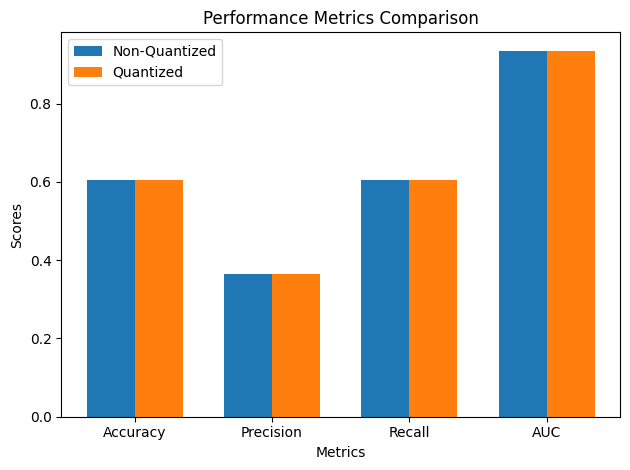

In [59]:
# Print performance metrics for non-quantized model
print("Non-Quantized Model Performance:")
print(f"Accuracy: {my_model_accuracy}")
print(f"Precision: {my_model_precision}")
print(f"Recall: {my_model_recall}")
print(f"AUC: {my_model_auc}")

# Print performance metrics for quantized model
print("\nQuantized Model Performance:")
print(f"Accuracy: {my_model_accuracy_quantized}")
print(f"Precision: {my_model_precision_quantized}")
print(f"Recall: {my_model_recall_quantized}")
print(f"AUC: {my_model_auc_quantized}")
# Plot performance metrics for non-quantized model
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']
values_non_quantized = [my_model_accuracy, my_model_precision, my_model_recall, my_model_auc]
values_quantized = [my_model_accuracy_quantized, my_model_precision_quantized, my_model_recall_quantized, my_model_auc_quantized]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_non_quantized, width, label='Non-Quantized')
rects2 = ax.bar(x + width/2, values_quantized, width, label='Quantized')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()